In [1]:
import alborexdata
import netCDF4
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
import cmocean
from importlib import reload

## Configuration

In [2]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

Domain

In [3]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

In [4]:
datafile = config["datafiles"]["adcp"]
os.path.exists(datafile)
figdir = "../figures/ADCP/"

Front

In [5]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

## Data reading and quality control

In [6]:
adcp = alborexdata.Adcp()
adcp.get_from_netcdf(datafile)
adcp.apply_qc(qf=1)
adcp.get_norm()

/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py:610: RuntimeWarning: invalid value encountered in sqrt
  self.velnorm = np.sqrt(self.u * self.u + self.v * self.v)


## Figures
### Projection

In [7]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='h')

### Quality flag for the whole section
Create colormap with 9 divisions

In [8]:
cmap_error = plt.cm.get_cmap('hot_r', 9)

Find where the ADCP is turned off for long periods

In [9]:
deltatime = adcp.time[1:] - adcp.time[:-1]
gaps = np.where(deltatime > 3600)[0]

In [10]:
flagmeaning = ["1: good", "2: probably good", "3: probably bad", "4: bad", "5", "6: spike", 
               "7", "8", "9: missing value"]

Compute ratio of good data over total data.

In [11]:
npoints = adcp.u.shape[0] * adcp.u.shape[1]
for ii in range(1, 10):
    print(str(len(np.where(adcp.qcu.flatten() == ii)[0]) / npoints * 100) + '%')

75.135663507109%
0.0011848341232227487%
0.0%
9.899289099526067%
0.0%
3.043838862559242%
0.0%
0.0%
11.920023696682465%


Same but for the first 200 meters

In [20]:
gooddepth = np.where(adcp.depth >= 200.)[0]
adcp.qcu200 = adcp.qcu[:, gooddepth]
npoints = adcp.qcu200.shape[0] * adcp.qcu200.shape[1]
for ii in range(1, 10):
    print(str(len(np.where(adcp.qcu200.flatten() == ii)[0]) / npoints * 100) + '%')

57.32293312269615%
0.0010970686326136564%
0.0%
16.339740214147795%
0.0%
4.697647884851676%
0.0%
0.0%
21.638581709671755%


### Make the QC plot

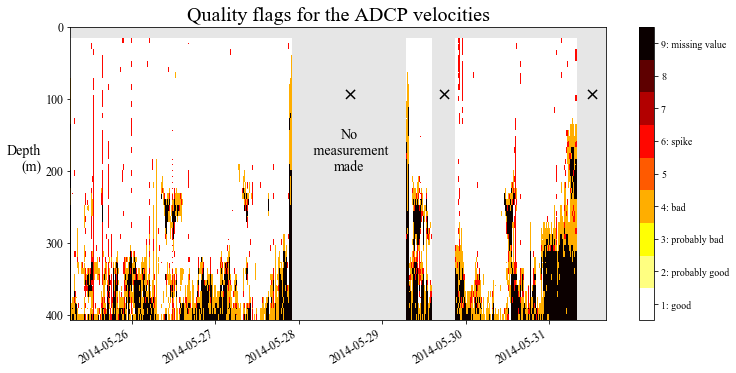

In [12]:
figname = "fig09b"
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
ax.set_facecolor(".9")

# Plot separate pcolor to avoid color interpolation during periods 
# without data

imin = 0
for nig, ig in enumerate(gaps):
    imax = ig
    plt.pcolormesh(adcp.dates[imin:imax], adcp.depth, adcp.qcu[imin:imax,:].T, 
                   cmap=cmap_error, vmin=0.5, vmax = 9.5)
    datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[ig+1]), adcp.timeunits)
    if nig < 2:
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    elif nig == 2:
        datemean = netCDF4.num2date(0.5 * (adcp.time[ig] + adcp.time[-1]), adcp.timeunits)
        plt.text(datemean, 100, r"$\times$", fontsize=18, ha="center")
    imin = imax+1
    
# Add text in no data period
datemean = netCDF4.num2date(0.5 * (adcp.time[gaps[0]] + adcp.time[gaps[0]+1]), adcp.timeunits)
plt.text(datemean, 200, "No\n measurement\nmade", 
         fontsize=14, ha="center")


plt.gca().invert_yaxis()
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar()
cb.set_ticks(range(0, 10))
cb.set_ticklabels(flagmeaning)
plt.yticks(np.arange(0, 401, 100.))
# cb.set_label("QF", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Quality flags for the ADCP velocities", fontsize=20)
plt.xlim(adcp.dates[0], adcp.dates[-1])
fig.autofmt_xdate()
plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Illustrates the result of the quality control applied to the velocity. They are mostly based on the tests applied on ADCP installed on a mooring (hence fixed) with some adaptations. The 3 main periods during which the ADCP was turned off are shown as the grey areas. Obviously no measurements are available in the first meters of the water column.

Overal the quality of the data tends to deteriorate (se dégrader) with depth where we find bad  and missing values. In the first 200~m, about 95\% of the measurements are considered as good. Below 200~m, the ratio drops to 57\% with more than 21% of missing values. Note that the flags 5, 7 and 8 were not used in this case but kept in the plot.

### Quiver plot all depths
Plot the velocity fields with arrows.     
The arrow lengths are all the same but the color change, so the visualisation of both the direction and the intensity is easier. No quiver key is needed.

In [32]:
llon, llat = m(adcp.lon, adcp.lat)
for idepth, depth in enumerate(adcp.depth):
    figname = "ADCP_{}".format(str(idepth).zfill(4))
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    m.plot(adcp.lon, adcp.lat, "k--", lw=.2, latlon=True)
    qv = plt.quiver(llon, llat, 
               adcp.u[:,idepth] / adcp.velnorm[:, idepth], 
               adcp.v[:,idepth] / adcp.velnorm[:, idepth], 
               adcp.velnorm[:,idepth], headwidth=0, scale=25, cmap=cmocean.cm.speed)
   
    cb = plt.colorbar(qv, shrink=0.8, extend="max")
    cb.set_label("$\|v\|$\n(m/s)", rotation=0, ha="left", fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.clim(0, 1.)
    m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
    m.drawparallels(np.arange(36.5, coordinates2[3], 0.25), labels=[1, 0, 0, 0],
                   fontname='Times New Roman', fontsize=14, 
                   linewidth=0.2, zorder=1, color=".6")
    m.drawmeridians(np.arange(-1, coordinates2[1], 0.25), labels=[0, 0, 0, 1],
                   fontname='Times New Roman', fontsize=14,
                    linewidth=0.2, zorder=1, color=".6")

    plt.title("Depth: {} m".format(depth), fontsize=20)
    plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

### Plot selected sections

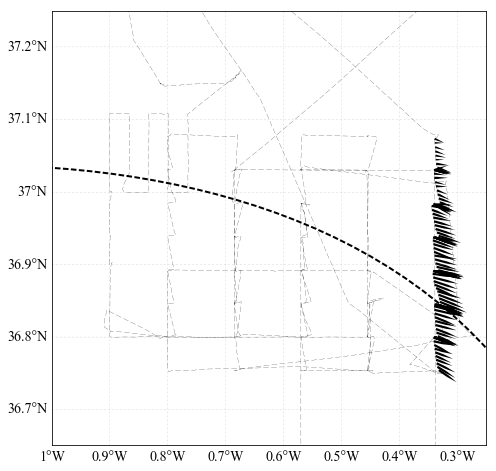

In [62]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
NN1, NN2 = 1462, 1600
NN1, NN2 = 1640, 1780
llon, llat = m(adcp.lon[NN1:NN2], adcp.lat[NN1:NN2])
m.plot(adcp.lon, adcp.lat, "k--", lw=.2, latlon=True)
#plt.plot(dataadcp["AnLLonDeg"], dataadcp["AnLLatDeg"], 'r--', lw=.2)

plt.quiver(llon, llat, adcp.u[NN1:NN2,0], adcp.v[NN1:NN2,0], headwidth=1)
m.plot(f.lon, f.lat, "k--", linewidth=2, latlon=True)
m.drawparallels(np.arange(36.5, coordinates2[3], 0.1), labels=[1, 0, 0, 0],
                   fontname='Times New Roman', fontsize=14, 
                   linewidth=0.2, zorder=1, color=".6")
m.drawmeridians(np.arange(-1, coordinates2[1], 0.1), labels=[0, 0, 0, 1],
               fontname='Times New Roman', fontsize=14,
                linewidth=0.2, zorder=1, color=".6")
plt.show()
plt.close()

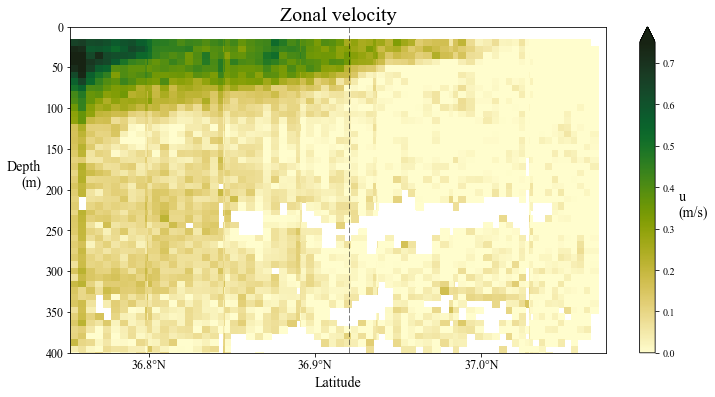

In [58]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
NN1, NN2 = 1462, 1600
plt.pcolormesh(adcp.lat[NN2:NN1:-1], adcp.depth, adcp.u[NN2:NN1:-1,:].T, 
               cmap=cmocean.cm.speed, vmin=0., vmax=.75)
# Front position
plt.vlines(36.92, 0, 400, colors='k', linestyles='--', linewidth=.5)
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar(extend="max")
cb.set_label("u\n(m/s)", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Zonal velocity", fontsize=20)
xticks = np.arange(36.5, 37.5, 0.1)
xticklabels = ["{}°N".format(np.round(xt,1)) for xt in xticks]
plt.xticks(xticks, xticklabels)
plt.xlim(adcp.lat[NN2], adcp.lat[NN1])
plt.ylim(0., 400.)
plt.gca().invert_yaxis()
#plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

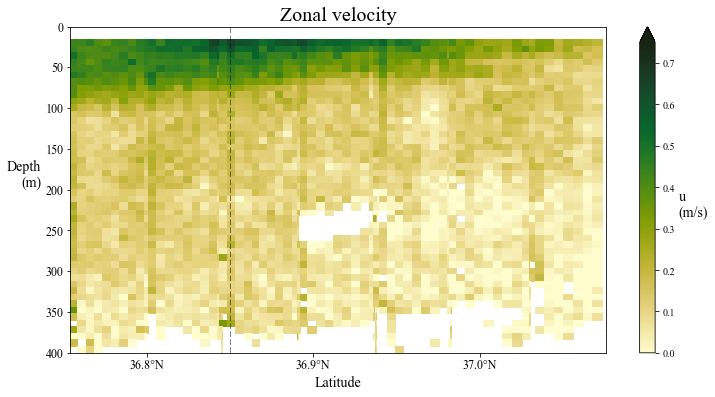

In [61]:
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
NN1, NN2 = 1640, 1780
plt.pcolormesh(adcp.lat[NN1:NN2], adcp.depth, adcp.u[NN1:NN2,:].T, 
               cmap=cmocean.cm.speed, vmin=0., vmax=.75)
# Front position
plt.vlines(36.85, 0, 400, colors='k', linestyles='--', linewidth=.5)
plt.xlabel("Latitude", fontsize=14)
plt.ylabel("Depth\n(m)", rotation=0, ha="right", fontsize=14)
cb = plt.colorbar(extend="max")
cb.set_label("u\n(m/s)", rotation=0, ha="left", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title("Zonal velocity", fontsize=20)
xticks = np.arange(36.5, 37.5, 0.1)
xticklabels = ["{}°N".format(np.round(xt,1)) for xt in xticks]
plt.xticks(xticks, xticklabels)
plt.xlim(adcp.lat[NN1], adcp.lat[NN2])
plt.ylim(0., 400.)
plt.gca().invert_yaxis()
#plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()